# Import Packages

In [1]:
import numpy as np
import pandas as pd

import inspect

from matplotlib import style; style.use('seaborn-notebook')
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt

# Class Definitions

In [2]:
class Error(Exception):
    pass


class InputError(Error):

    def __init__(self, expression, message):
        self.expression = expression
        self.message = message


class MotionDescriptor(object):
    
    def __init__(self):
        self.wrap_func = self.__get_wrap_func()
        
        self.__velocity = []
        self.__acceleration = []
        self.__jerk = []
        
        self.eps = 1e-10
        
    def norm(self, ndsig):
        return np.linalg.norm(ndsig, axis=-1)
    
    def center_of_mass(self, x, markers=[], weights=[]):
        if not np.any(markers):
            markers = np.arange(x.shape[1])
            
        if not np.any(weights):
            weights = np.ones(markers.shape) / len(markers)
        
        return np.sum(np.multiply(x[:, markers, :], weights), axis=1) / np.sum(weights)
        
    def quantity_of_motion(self, vel, weights=[]):
        marker_dim = vel.shape[-2]
        if len(weights) is not marker_dim:
            weights = np.ones(marker_dim) / marker_dim
            
        speed_k = self.norm(vel)
        return np.sum(np.multiply(speed_k, weights), axis=-1) / np.sum(weights)
    
    def velocity(self, x, dt=1):
        vel_transients = 2
        x = self.__check_wrap(x, vel_transients)
        v = (x[2:] - x[0:-2]) / (2*dt)
        return np.squeeze(v)
        
    def acceleration(self, x, dt=1):
        acc_transients = 2
        x = self.__check_wrap(x, acc_transients)
        a = (x[2:] - 2.*x[1:-1] + x[0:-2]) / (dt**2)
        return np.squeeze(a)
    
    def jerk(self, x, dt=1):
        jrk_transients = 4
        x = self.__check_wrap(x, jrk_transients)
        j = (x[4:] - 2.*x[3:-1] + 2.*x[0:-4] - x[1:-3]) / (2*dt**3)
        return np.squeeze(j)
    
    def __curv2d(self, vel, acc):
        A = np.stack((acc, vel), axis=-1)
        vel_dot = np.sum(np.multiply(vel, vel), axis=-1)
        return np.abs(np.linalg.det(A)) / np.power(vel_dot, 3.0/2.0)
        
    def __curv3d(self, vel, acc):
        norm_cross = self.norm(np.cross(acc, vel))
        vel_cubed = np.power(self.norm(vel), 3.0)
        return norm_cross / (vel_cubed + self.eps)
    
    def curvature(self, vel, acc):
        dim = vel.shape[-1]
        if not (1 < dim < 4):
            s = inspect.stack()[0].function
            raise InputError(
                'An error occured while calling function \"%s\"'% s,
                'Curvature is udefined for signals with dimensions != 2 or 3'
            )
        
        if dim == 2:
            return self.__curv2d(vel, acc)
        elif dim == 3:
            return self.__curv3d(vel, acc)

    '''
        UTILITY METHODS
    '''
        
    def set_wrap_func(self, mode):
        self.wrap_func = self.__get_wrap_func(mode=mode)

    def __check_wrap(self, x, transients):
        if self.wrap_func:
            x = self.wrap_func(x, transients)   
        return x
        
    def __get_wrap_func(self, mode='repeat'):
        def wrap_edges(vec, k):
            d = vec.shape
            if len(d) == 1:
                d += (1, )

            tmp = np.resize(vec, (d[0] + k, *d[1:]))
            tmp[k//2:] = tmp[:-k//2]

            if mode == 'repeat':
                tmp[:k//2] = vec[0]
                tmp[-k//2:] = vec[-1]

            elif mode == 'zero':
                tmp[:k//2] = tmp[-k//2:] = 0

            elif mode == 'wrap':
                tmp[:k//2] = vec[-k//2:]
                tmp[-k//2:] = vec[:k//2]

            return tmp
        
        return wrap_edges if mode else None        
        

class LabanDescriptor(MotionDescriptor):
    
    def __init__(self, motion_data, num_markers, num_dof, sr=1, marker_ids=None):
        super().__init__()
        
        self.motion_data     = motion_data.reshape((-1, num_markers, num_dof))
        self.euler_positions = self.motion_data
        
        self.fs = 1 / sr
        self.num_markers = num_markers
        
        self.std_weights = np.ones(num_markers)
            
    def weight(self, time_window_len, weights=[]):
        vel = self.norm(self.velocity(self.euler_positions, self.fs))
        vel_windowed = self.__window_input(vel, time_window_len)
        _weights = self.__check_weights(weights)
        weight_k = np.sum(np.multiply(np.power(vel_windowed, 2), _weights), axis=-1)
        
        return np.amax(weight_k, axis=-1)
    
    def space(self, time_window_len, weights=[]):
        pos = self.euler_positions
        pos_windowed = self.__window_input(pos, time_window_len)
        
        displacement_n = pos_windowed[:, 1:] - pos_windowed[:, 0:-1]
        displacement_t = pos_windowed[:, -1] - pos_windowed[:, 0]
        
        disp_n_norm = self.norm(displacement_n)
        disp_t_norm = self.norm(displacement_t)
        
        disp_n_sum = np.sum(disp_n_norm, axis=1)
        
        disp_avg = disp_n_sum / (disp_t_norm + self.eps)
        
        _weights = self.__check_weights(weights)
        disp_avg_s = np.multiply(disp_avg, _weights)
        
        return np.sum(disp_avg_s, axis=-1)
                
    def time(self, time_window_len, weights=[]):
        acc = self.norm(self.acceleration(self.euler_positions, self.fs))
        acc_windowed = self.__window_input(acc, time_window_len)
        time_k = np.sum(acc_windowed, axis=1) / time_window_len
        _weights = self.__check_weights(weights)
        return np.sum(np.multiply(time_k, _weights), axis=-1)
        
    def flow(self, time_window_len, weights=[]):
        jrk = self.norm(self.jerk(self.euler_positions, self.fs))
        jrk_windowed = self.__window_input(jrk, time_window_len)
        flow_k = np.sum(jrk_windowed, axis=1) / time_window_len
        _weights = self.__check_weights(weights)
        return np.sum(np.multiply(flow_k, _weights), axis=-1)
    
    '''
        UTILITY METHODS
    '''
    
    def __check_weights(self, weights):
        if not np.any(weights):
            return self.std_weights
        
        if len(weights) is not self.num_markers:
            s = inspect.stack()[1].function
            raise InputError(
                'An error occured while calling function \"%s\"'% s,
                'Input number of weights does not match number of markers'
            )
            
        return weights
    
    def __window_input(self, ndsig, wlen):
        d = ndsig.shape
        if len(d) == 1:
            d += (1, )
        
        wmod = d[0] % wlen
        k = wlen - wmod
        return np.resize(ndsig, (d[0] + k, wlen, *d[1:]))
    

# Read Example Mocap Data

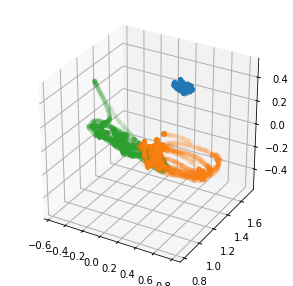

In [3]:
def read_tsv_clean(p, h):
    tsv_data = pd.read_csv(p, sep='\t', skiprows=h, header=None)
    tsv_data = tsv_data.dropna(axis=1)
    return np.array(tsv_data)

path_pos = '../../mocapData/SmoothedPos.tsv'
pos_dat = read_tsv_clean(path_pos, 10)

# Make some pretty plots
fig0 = plt.figure(num=0, figsize=(5, 5))
ax0 = fig0.add_subplot(111, projection='3d')
X = pos_dat.reshape((-1, 3, 3))
ax0.scatter(X[:, 0, 0], X[:, 0, 2], X[:, 0, 1], alpha=0.1)
ax0.scatter(X[:, 1, 0], X[:, 1, 2], X[:, 1, 1], alpha=0.1)
ax0.scatter(X[:, 2, 0], X[:, 2, 2], X[:, 2, 1], alpha=0.1)
plt.show()

# Compute and Plot Some Motion Descriptors

In [4]:
# Declare the global variables we need.
# From the file we can infer that we are working with
# 3 distinct markers (Head, Left/Right hand). 
# The sampling frequency is provided as 100 samples/s.
# Finally, the data is specified in 3 DOF (x, y, z)-coordinates.
N_MARKERS = 3
N_DOF     = 3
SR        = 100
DT        = 1/SR

In [5]:
# Instantiate an object from the LabanDescriptor class
laban_object = LabanDescriptor(
    motion_data = pos_dat, 
    num_markers = N_MARKERS, 
    num_dof     = N_DOF, 
    sr          = SR
)

# Set the edge-wrapping scheme
# Possible options are:
# [1] 'zero'
# [2] 'repeat'
# [3] 'wrap'
# [4] None
laban_object.set_wrap_func(
    mode = 'repeat'
)

In [6]:
# All functions expects a data input array of the form:
#
#           [SAMPLES, MARKERS, DOF]
#
# Since the Laban subclass does a reshape upon 
# instatiation, we will use the class attribute
positions = laban_object.motion_data

# Compute the Quantity of Motion (QoM). 
# We do not want equal contribution from every marker. 
# In this case we are gonna put less emphasis on the 'head' marker. 

qom_com_weights = [0.25, 0.375, 0.375]

# We need the velocity to compute QoM.
velocity = laban_object.velocity(positions, DT)

qom = laban_object.quantity_of_motion(
    vel     = velocity,
    weights = qom_com_weights
)

# Compute Center of Mass (CoM). 
# Again, we do not want equal 
# contribution from every marker.
# We are however, including EVERY marker
# in the CoM estimate.
markers = [0, 1, 2]

com = laban_object.center_of_mass(
    x       = positions,
    markers = markers,
    weights = qom_com_weights
)


# Compute the curvature. For that,
# we need the acceleration (as well as the velocity)
acceleration = laban_object.acceleration(positions, DT)

# Curvature is not a global descriptor. It will return
# a kinematic signal for each marker.
curvature = laban_object.curvature(velocity, acceleration)

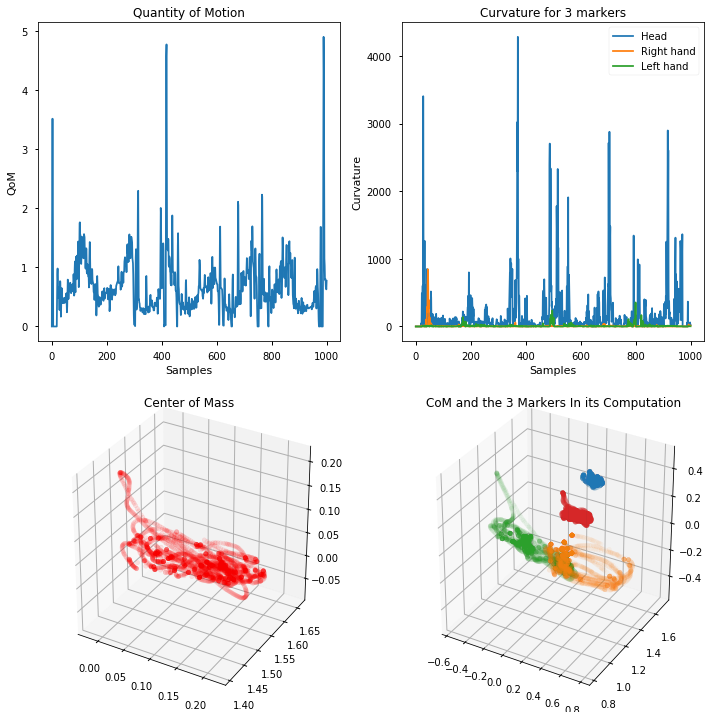

In [7]:
# Make some pretty plots 
fig1 = plt.figure(num=1, figsize=(10, 10))

ax0 = fig1.add_subplot(221)
ax0.plot(qom[0:1000])
ax0.set_title('Quantity of Motion')
ax0.set_ylabel('QoM')
ax0.set_xlabel('Samples')

ax1 = fig1.add_subplot(222)
ax1.plot(curvature[0:1000, 0], label='Head')
ax1.plot(curvature[0:1000, 1], label='Right hand')
ax1.plot(curvature[0:1000, 2], label='Left hand')
ax1.set_title('Curvature for 3 markers')
ax1.set_ylabel('Curvature')
ax1.set_xlabel('Samples')
ax1.legend()

ax2 = fig1.add_subplot(223, projection='3d')
ax2.scatter(com[:, 0], com[:, 2], com[:, 1], color='r', alpha=0.1)
ax2.set_title('Center of Mass')

ax3 = fig1.add_subplot(224, projection='3d')
ax3.scatter(X[:, 0, 0], X[:, 0, 2], X[:, 0, 1], alpha=0.05)
ax3.scatter(X[:, 1, 0], X[:, 1, 2], X[:, 1, 1], alpha=0.05)
ax3.scatter(X[:, 2, 0], X[:, 2, 2], X[:, 2, 1], alpha=0.05)
ax3.scatter(com[:, 0], com[:, 2], com[:, 1], alpha=0.1, label='CoM')
ax3.set_title('CoM and the 3 Markers In its Computation')

plt.tight_layout()

# Compute and Plot Some LMA Effort Descriptors

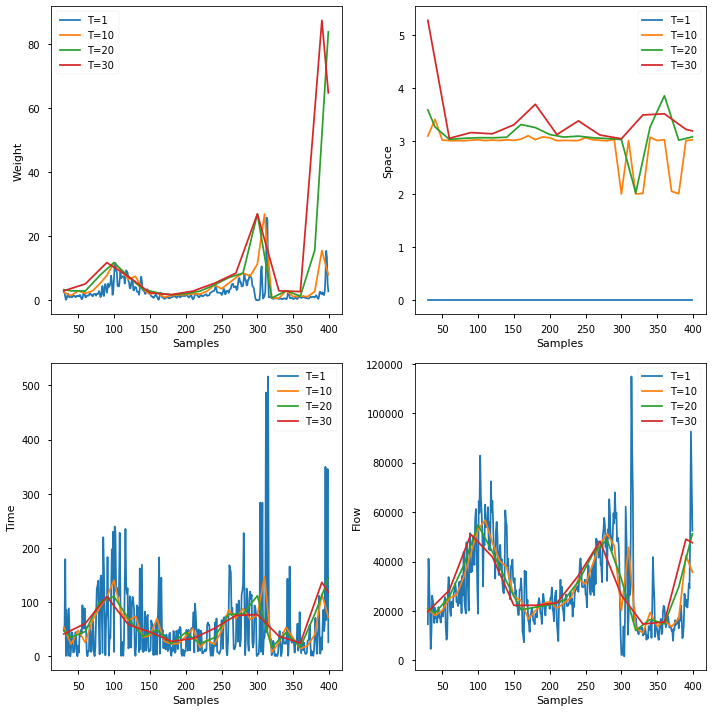

In [8]:
def get_values_for_window(effort_func, wlens):
    res = []
    for w in wlens:
        effort = effort_func(w)
        nsamps = len(effort)
        samps = np.arange(nsamps)
        xvals = np.linspace(0, nsamps, nsamps * w)
        y = np.interp(xvals, samps, effort)
        res.append(y)
    
    return res
    
def plot_efforts_on_ax(ax, values, offset, lim, labels):
    xvals = np.arange(offset, lim)
    for i, v in enumerate(values):
        ax.plot(xvals, v[offset:lim], label='T=%d'%labels[i])
        

fig2 = plt.figure(num=2, figsize=(10, 10))
windows = [1, 10, 20, 30]
offset = 30
limit = 400

def plot_on_fig(effort_func, subidx):
    ax = fig2.add_subplot(subidx)
    weight_values = get_values_for_window(
        effort_func,
        windows
    )
    
    plot_efforts_on_ax(ax, weight_values, offset, limit, windows)
    return ax


ax0 = plot_on_fig(laban_object.weight, 221)
ax0.set_xlabel('Samples')
ax0.set_ylabel('Weight')
ax0.legend()

ax1 = plot_on_fig(laban_object.space, 222)
ax1.set_xlabel('Samples')
ax1.set_ylabel('Space')
ax1.legend()

ax2 = plot_on_fig(laban_object.time, 223)
ax2.set_xlabel('Samples')
ax2.set_ylabel('Time')
ax2.legend()

ax3 = plot_on_fig(laban_object.flow, 224)
ax3.set_xlabel('Samples')
ax3.set_ylabel('Flow')
ax3.legend()

plt.tight_layout()